In [172]:
import importlib_resources
import pandas as pd
import numpy as np
np.random.seed(331)
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error
sns.set_theme(font_scale=1.5)

# Load data:

In [173]:
filepath = importlib_resources.files("materials").joinpath("HR_data.csv")
df = pd.read_csv(filepath, sep=None, engine="python", header=0)

# Delete ID column which has no header in the .csv
df = df.drop(columns="Unnamed: 0")

HR_features = ["HR_Mean", "HR_Median", "HR_std", "HR_Min", "HR_Max", "HR_AUC"]

In [174]:
df.head(10)

,HR_Mean,HR_Median,HR_std,HR_Min,HR_Max,HR_AUC,Round,Phase,Individual,Puzzler,Frustrated,Cohort
0,77.965186,78.000,3.345290,73.23,83.37,22924.945,round_3,phase3,1,1,1,D1_1
1,70.981097,70.570,2.517879,67.12,78.22,21930.400,round_3,phase2,1,1,5,D1_1
2,73.371959,73.360,3.259569,67.88,80.22,21647.085,round_3,phase1,1,1,0,D1_1
3,78.916822,77.880,4.054595,72.32,84.92,25258.905,round_2,phase3,1,1,1,D1_1
4,77.322226,74.550,6.047603,70.52,90.15,23890.565,round_2,phase2,1,1,5,D1_1
5,74.372061,74.050,2.061858,71.27,79.22,21940.505,round_2,phase1,1,1,0,D1_1
6,77.253401,77.750,3.204755,72.43,82.90,22867.070,round_4,phase3,1,1,0,D1_1
7,72.699901,72.750,2.692685,66.25,77.12,21880.330,round_4,phase2,1,1,4,D1_1
8,73.890960,74.370,3.479808,67.48,80.85,23789.395,round_4,phase1,1,1,0,D1_1
9,72.625483,72.275,3.687537,67.55,81.78,20985.990,round_1,phase3,1,1,2,D1_1


## Data summary:

In [175]:
summary = df[["HR_Mean", "HR_Median", "HR_std", "HR_Min", "HR_Max", "HR_AUC", "Individual", "Puzzler", "Frustrated"]].describe()
summary.loc["median"] = df[["HR_Mean", "HR_Median", "HR_std", "HR_Min", "HR_Max", "HR_AUC", "Individual", "Puzzler", "Frustrated"]].median() # Adding median to the summary
order = ['count', 'mean', 'median', 'std', 'min', '25%', '50%', '75%', 'max'] # Reordering the summary to have median right below mean

summary.loc[order]

,HR_Mean,HR_Median,HR_std,HR_Min,HR_Max,HR_AUC,Individual,Puzzler,Frustrated
count,168.000000,168.000000,168.000000,168.000000,168.000000,168.000000,168.00000,168.000000,168.000000
mean,76.009226,74.821458,6.041234,67.422679,89.062024,23398.551815,7.50000,0.500000,2.291667
median,75.618503,74.625000,4.678773,67.540000,87.355000,22493.687500,7.50000,0.500000,2.000000
std,7.501301,8.101459,4.267282,7.042010,12.764559,3589.600223,4.04318,0.501495,1.924796
min,57.341463,54.130000,0.844255,52.180000,70.150000,15975.450000,1.00000,0.000000,0.000000
25%,70.952240,70.175000,3.092851,62.645000,79.752500,20805.553750,4.00000,0.000000,1.000000
50%,75.618503,74.625000,4.678773,67.540000,87.355000,22493.687500,7.50000,0.500000,2.000000
75%,80.308459,79.010000,7.281001,71.922500,94.682500,25645.200000,11.00000,1.000000,4.000000
max,96.159341,94.880000,21.880307,82.680000,137.670000,35299.460000,14.00000,1.000000,8.000000


# Data Preprocessing

In [176]:
print("The dataset contains responses from {} unique individuals".format(len(df["Individual"].unique())))

The dataset contains responses from 14 unique individuals


In [177]:
for i in df["Individual"].unique():
    print(f"Individual {i} has", df["Individual"].where(df["Individual"] == i).count(), "datapoints.")

Individual 1 has 12 datapoints.
Individual 2 has 12 datapoints.
Individual 3 has 12 datapoints.
Individual 4 has 12 datapoints.
Individual 5 has 12 datapoints.
Individual 6 has 12 datapoints.
Individual 7 has 12 datapoints.
Individual 8 has 12 datapoints.
Individual 9 has 12 datapoints.
Individual 10 has 12 datapoints.
Individual 11 has 12 datapoints.
Individual 12 has 12 datapoints.
Individual 13 has 12 datapoints.
Individual 14 has 12 datapoints.


In [178]:
print("There are {} datapoints in the dataset.".format(len(df)))

There are 168 datapoints in the dataset.


In [179]:
print("Feature count:", len(df.columns))

Feature count: 12


In [180]:
print("Does the data contain NaN's?: {}.".format( df.isnull().values.any() ))
print("There are {} NaN values in the dataset.".format(df.isnull().sum().sum()))

Does the data contain NaN's?: False.
There are 0 NaN values in the dataset.


## Handling "Frustrated" Class imbalance

Using SMOTE and later StratifiedGroupKFold CV aswell.

Distribution of 'Frustrated' values in data (e.g. how many 0,1,2.. etc.): [29, 45, 31, 16, 23, 14, 5, 2, 3, 0, 0]
Sum of all frustrated_count: 168
Proportion analysis: [17.26, 26.79, 18.45, 9.52, 13.69, 8.33, 2.98, 1.19, 1.79, 0.0, 0.0] %


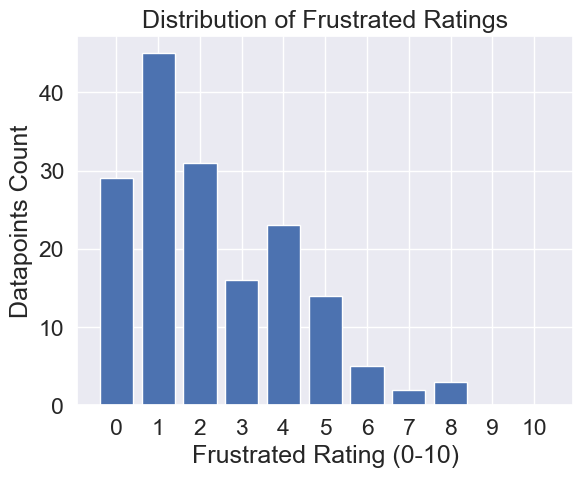

In [181]:
frustrated_count = []
for i in range(0, 11):
    num = (df["Frustrated"] == i).sum()
    
    frustrated_count.append( num )

print("Distribution of 'Frustrated' values in data (e.g. how many 0,1,2.. etc.):", frustrated_count)
print("Sum of all frustrated_count:", np.sum(frustrated_count))

print("Proportion analysis: {} %".format( [round((i/len(df["Frustrated"]))*100, 2) for i in frustrated_count] ) )

plt.figure()
plt.bar(np.arange(0,11), frustrated_count)
plt.xlabel('Frustrated Rating (0-10)')
plt.ylabel('Datapoints Count')
plt.title('Distribution of Frustrated Ratings')
plt.xticks(np.arange(0,11))
plt.savefig("distribution_of_frustrated_ratings.pdf", bbox_inches='tight')

In [182]:
feature = "Frustrated"
for i in np.sort(df[feature].unique()):
    print(f"{feature} {i} has", df[feature].where(df[feature] == i).count(), "datapoints.")

Frustrated 0 has 29 datapoints.
Frustrated 1 has 45 datapoints.
Frustrated 2 has 31 datapoints.
Frustrated 3 has 16 datapoints.
Frustrated 4 has 23 datapoints.
Frustrated 5 has 14 datapoints.
Frustrated 6 has 5 datapoints.
Frustrated 7 has 2 datapoints.
Frustrated 8 has 3 datapoints.


In [183]:
print("Frustrated Level 8 at indices:", df.index[df["Frustrated"] == 7].tolist())

df.iloc[df.index[df["Frustrated"] == 7].tolist()]

Frustrated Level 8 at indices: [43, 64]


,HR_Mean,HR_Median,HR_std,HR_Min,HR_Max,HR_AUC,Round,Phase,Individual,Puzzler,Frustrated,Cohort
43,68.865497,69.425,2.723403,63.27,73.12,20725.905,round_4,phase2,4,1,7,D1_1
64,83.983399,83.535,2.028127,80.82,94.28,25611.370,round_2,phase2,6,0,7,D1_1


In [184]:
print("Frustrated Level 8 at indices:", df.index[df["Frustrated"] == 8].tolist())

df.iloc[df.index[df["Frustrated"] == 8].tolist()]

Frustrated Level 8 at indices: [103, 139, 163]


,HR_Mean,HR_Median,HR_std,HR_Min,HR_Max,HR_AUC,Round,Phase,Individual,Puzzler,Frustrated,Cohort
103,83.741293,85.21,4.214470,72.88,87.48,24540.430,round_4,phase2,9,1,8,D1_2
139,81.151092,75.87,10.568501,70.15,106.92,23705.220,round_4,phase2,12,1,8,D1_2
163,73.594539,72.38,9.474556,57.43,93.53,21482.985,round_4,phase2,14,0,8,D1_2


In [185]:
for i in np.sort(df["Phase"].unique()):
    print(f"Phase {i[-1]} has", (df["Phase"] == i).sum(), "datapoints. With a mean Frustration Level of:", np.median( df["Frustrated"].loc[df.index[df["Phase"] == i].tolist()] ) )

Phase 1 has 56 datapoints. With a mean Frustration Level of: 1.0
Phase 2 has 56 datapoints. With a mean Frustration Level of: 4.0
Phase 3 has 56 datapoints. With a mean Frustration Level of: 1.5


### Integer-encode "Phase"

In [186]:
df['Phase'] = df['Phase'].str.replace('phase', '').astype(int)

Distribution of 'Frustrated' values in data (e.g. how many 0,1,2.. etc.): [45, 45, 45, 45, 45, 45, 45, 45, 45, 0, 0]
Sum of all frustrated_count: 405
Proportion analysis: [26.79, 26.79, 26.79, 26.79, 26.79, 26.79, 26.79, 26.79, 26.79, 0.0, 0.0] %


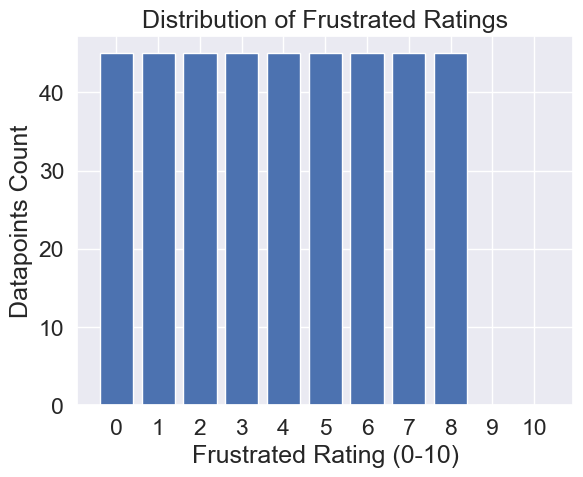

In [187]:
from imblearn.over_sampling import SMOTE

res_features = HR_features + ["Individual"] + ["Phase"] + ["Puzzler"]

sm = SMOTE(random_state=331, k_neighbors=1)
X_res, y_res = sm.fit_resample(df[res_features], df["Frustrated"])

frustrated_count = []
for i in range(0, 11):
    num = (y_res == i).sum()
    
    frustrated_count.append( num )

print("Distribution of 'Frustrated' values in data (e.g. how many 0,1,2.. etc.):", frustrated_count)
print("Sum of all frustrated_count:", np.sum(frustrated_count))

print("Proportion analysis: {} %".format( [round((i/len(df["Frustrated"]))*100, 2) for i in frustrated_count] ) )

plt.figure()
plt.bar(np.arange(0,11), frustrated_count)
plt.xlabel('Frustrated Rating (0-10)')
plt.ylabel('Datapoints Count')
plt.title('Distribution of Frustrated Ratings')
plt.xticks(np.arange(0,11))
plt.show()

#### Original Frustrated Level 8 individuals:

In [188]:
df.iloc[df.index[df["Frustrated"] == 8].tolist()]

,HR_Mean,HR_Median,HR_std,HR_Min,HR_Max,HR_AUC,Round,Phase,Individual,Puzzler,Frustrated,Cohort
103,83.741293,85.21,4.214470,72.88,87.48,24540.430,round_4,2,9,1,8,D1_2
139,81.151092,75.87,10.568501,70.15,106.92,23705.220,round_4,2,12,1,8,D1_2
163,73.594539,72.38,9.474556,57.43,93.53,21482.985,round_4,2,14,0,8,D1_2


In [215]:
df.head(5)

,HR_Mean,HR_Median,HR_std,HR_Min,HR_Max,HR_AUC,Round,Phase,Individual,Puzzler,Frustrated,Cohort
0,77.965186,78.00,3.345290,73.23,83.37,22924.945,round_3,3,1,1,1,D1_1
1,70.981097,70.57,2.517879,67.12,78.22,21930.400,round_3,2,1,1,5,D1_1
2,73.371959,73.36,3.259569,67.88,80.22,21647.085,round_3,1,1,1,0,D1_1
3,78.916822,77.88,4.054595,72.32,84.92,25258.905,round_2,3,1,1,1,D1_1
4,77.322226,74.55,6.047603,70.52,90.15,23890.565,round_2,2,1,1,5,D1_1


In [189]:
df_new_eights = X_res.iloc[X_res.index[y_res == 8].tolist()]
df_new_eights

,HR_Mean,HR_Median,HR_std,HR_Min,HR_Max,HR_AUC,Individual,Phase,Puzzler
103,83.741293,85.210000,4.214470,72.880000,87.480000,24540.430000,9,2,1
139,81.151092,75.870000,10.568501,70.150000,106.920000,23705.220000,12,2,1
163,73.594539,72.380000,9.474556,57.430000,93.530000,21482.985000,14,2,0
363,81.709094,77.882098,9.199665,70.738118,102.732079,23885.147637,11,2,1
364,81.665406,77.724562,9.306837,70.692072,103.059970,23871.060329,11,2,1
365,82.256832,79.857186,7.856006,71.315420,98.621188,24061.765822,10,2,1
366,75.618164,73.314613,9.767512,60.836383,97.115807,22078.093754,13,2,0
367,83.515902,84.397266,4.767376,72.642445,89.171600,24467.752963,9,2,1
368,83.624741,84.789726,4.500384,72.757157,88.354747,24502.847844,9,2,1
369,81.547956,77.301053,9.594951,70.568284,103.941450,23833.188883,11,2,1


## Standardize data:

In [190]:
from sklearn.preprocessing import StandardScaler

# Standardize the HR data
X_res_no_individual = X_res.drop(columns=["Individual", "Phase", "Puzzler"])
X_res_std = (X_res_no_individual - X_res_no_individual.mean()) / X_res_no_individual.std()
X_res_std["Individual"] = X_res["Individual"]
X_res_std["Phase"] = X_res["Phase"]
X_res_std["Puzzler"] = X_res["Puzzler"]

X_res_std.head(5)

,HR_Mean,HR_Median,HR_std,HR_Min,HR_Max,HR_AUC,Individual,Phase,Puzzler
0,0.235850,0.387839,-0.657955,0.831400,-0.529700,-0.125213,1,3,1
1,-0.858708,-0.708323,-0.883673,-0.147374,-1.002389,-0.462261,1,2,1
2,-0.484008,-0.296709,-0.681340,-0.025628,-0.818820,-0.558276,1,1,1
3,0.384991,0.370135,-0.464456,0.685625,-0.387434,0.665758,1,3,1
4,0.135084,-0.121146,0.079238,0.397279,0.092597,0.202032,1,2,1


## Split training and test set:

In [216]:
## Split the data into a Training set (80%) and a Test set (20%)
from sklearn.model_selection import GroupShuffleSplit

# To avoid splitting the individuals use GroupShuffleSplit
individuals = X_res["Individual"]

train_indices, test_indices = next(GroupShuffleSplit(n_splits=1, train_size=.8, random_state=331).split(X=X_res_std, y=y_res, groups=individuals))

X_train, y_train = X_res_std.loc[train_indices], y_res.loc[train_indices].values.flatten()
X_test, y_test = X_res_std.loc[test_indices], y_res.loc[test_indices].values.flatten()

In [194]:
# The distribution of Frustrated ratings in the training set
print("The distribution of Frustrated ratings in the training set:")
for i in np.unique(y_train):
    print("Frustrated:", i, "Count:", np.count_nonzero(y_train == i))


# The distribution of Frustrated ratings in the test set
print("\nThe distribution of Frustrated ratings in the test set:")
for i in np.unique(y_test):
    print("Frustrated:", i, "Count:", np.count_nonzero(y_test == i))

The distribution of Frustrated ratings in the training set:
Frustrated: 0 Count: 27
Frustrated: 1 Count: 35
Frustrated: 2 Count: 41
Frustrated: 3 Count: 43
Frustrated: 4 Count: 41
Frustrated: 5 Count: 32
Frustrated: 6 Count: 41
Frustrated: 7 Count: 45
Frustrated: 8 Count: 24

The distribution of Frustrated ratings in the test set:
Frustrated: 0 Count: 18
Frustrated: 1 Count: 10
Frustrated: 2 Count: 4
Frustrated: 3 Count: 2
Frustrated: 4 Count: 4
Frustrated: 5 Count: 13
Frustrated: 6 Count: 4
Frustrated: 8 Count: 21


In [195]:
# Unique individuals in X_train
uniqueList_X_train = X_train.loc[X_train.index.isin(train_indices)]["Individual"].unique()
points_X_train = len(X_train.loc[X_train.index.isin(train_indices)]["Individual"])

print("List of unique individuals in X_train:", uniqueList_X_train)
print("Amount of datapoints in X_train: {} ({} %)".format(points_X_train, round((points_X_train/405)*100, 2)))

List of unique individuals in X_train: [ 2  3  4  5  6  7  8  9 12 13 14]
Amount of datapoints in X_train: 329 (81.23 %)


In [196]:
# Unique individuals in X_test
uniqueList_X_test = X_test.loc[X_test.index.isin(test_indices)]["Individual"].unique()
points_X_test = len(X_test.loc[X_test.index.isin(test_indices)]["Individual"])

print("List of unique individuals in X_test:", uniqueList_X_test)
print("Amount of datapoints in X_test: {} ({} %)".format(points_X_test, round((points_X_test/405)*100, 2)))

List of unique individuals in X_test: [ 1 10 11]
Amount of datapoints in X_test: 76 (18.77 %)


# Model 1: Random Forest

In [197]:
from sklearn.model_selection import StratifiedGroupKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.dummy import DummyClassifier


# Baseline model
baseline_model = DummyClassifier(strategy="constant", random_state=331, constant=int(summary["Frustrated"]["median"]))



fold_data = []

## -- Perform Stratified K-fold cross-validation to evaluate model generalization
## -- Compare it to a baseline

# Split into stratified KFolds
sgkf = StratifiedGroupKFold(n_splits=10, shuffle=True, random_state=331)
for i, (train_idx, test_idx) in enumerate(sgkf.split(X_train, y_train, groups=individuals.loc[train_indices])):
    fold_data.append((X_train.iloc[train_idx], y_train[train_idx], X_train.iloc[test_idx], y_train[test_idx]))





## Model
# Outer loopo: Hyperparameter tuning of n_neighbors

params = [1, 2, 3, 5, 10, 20, 50, 100, 400, 500, 600, 700, 1000, 1200]
avg_scores = np.empty(shape=(2, len(params)))
avg_scores[0,:] = params


RFC_CV_scores = np.empty(shape=(len(params), 10))
RFC_CV_mse = np.empty(shape=(len(params), 10))


for k in range(len(params)):
    
    rfc = RandomForestClassifier(n_estimators=params[k], random_state=331)

    rfc_scores = []
    rfc_mse = []
    baseline_scores = []

    # Inner loop: Cross-validation for generalisation estimation
    for i, (X_train_sgkf, y_train_sgkf, X_test_sgkf, y_test_sgkf) in enumerate(fold_data):
        # print("Fold {}:   Train-IDs: {}. Test-IDs: {}".format(i, X_train_sgkf["Individual"].unique(), X_test_sgkf["Individual"].unique()))

        rfc.fit(X_train_sgkf, y_train_sgkf)    
        rfc_scores.append( rfc.score(X_test_sgkf, y_test_sgkf) )
        rfc_mse.append( mean_squared_error(y_true=y_test_sgkf, y_pred=rfc.predict(X_test_sgkf)) )

        # Baseline model
        baseline_model.fit(X_train_sgkf, y_train_sgkf)
        baseline_scores.append( baseline_model.score(X_test_sgkf, y_test_sgkf) )

        # if (i == 2):
        #     print("Fold {}:   Train-IDs: {}. Test-IDs: {}".format(i, X_train_sgkf["Individual"].unique(), X_test_sgkf["Individual"].unique()))
    


    RFC_CV_scores[k] = rfc_scores
    RFC_CV_mse[k] = rfc_mse
    avg_acc = np.mean(rfc_scores)
    avg_mse = np.mean(rfc_mse)
    avg_scores[1,k] = avg_acc
    print(f"RandomForestClassifier Average Accuracy (n_estimators={params[k]}): {avg_acc:.2f},    Mean MSE: {avg_mse:.2f}")
    # print("\nBaseline CV-scores:", baseline_scores)
    # print(f"Baseline Accuracy: {np.mean(baseline_scores):.2f}")


rfc_best_k = np.where(avg_scores[1,:] == np.max(avg_scores[1,:]))[0][0]
print("\nBest choice of n_estimators by Accuracy:", params[rfc_best_k])
print(f"Best choice by MSE: {np.min(np.mean(RFC_CV_mse, axis=1)):.2f}")


print(f"\nRandomForestClassifier CV-scores (n_estimators={params[rfc_best_k]}):", RFC_CV_scores[rfc_best_k])

rfc = RandomForestClassifier(n_estimators=params[rfc_best_k])
rfc.fit(X_train, y_train)

RFC_y_pred_test = rfc.predict(X_test)

print(f"\n\nRandomForestClassifier predictions: {RFC_y_pred_test}")
print(f"\n\nRandomForestClassifier truth: {y_test}")

print(f"\n\nRandomForestClassifier final Accuracy-test score: {rfc.score(X_test, y_test):.2f}")
print(f"\nRandomForestClassifier final MSE: {mean_squared_error(y_true=y_test, y_pred=RFC_y_pred_test):.2f}")

print("---")
# Baseline model
baseline_model = DummyClassifier(strategy="constant", random_state=331, constant=int(6))
baseline_model.fit(X_train, y_train)
print("Baseline:", baseline_model.score(baseline_model.predict(X_test), y_test))
print("Baseline MSE:", mean_squared_error(y_pred=baseline_model.predict(X_test), y_true=y_test))

RandomForestClassifier Average Accuracy (n_estimators=1): 0.27,    Mean MSE: 9.12
RandomForestClassifier Average Accuracy (n_estimators=2): 0.23,    Mean MSE: 8.48
RandomForestClassifier Average Accuracy (n_estimators=3): 0.35,    Mean MSE: 7.81
RandomForestClassifier Average Accuracy (n_estimators=5): 0.38,    Mean MSE: 6.53
RandomForestClassifier Average Accuracy (n_estimators=10): 0.42,    Mean MSE: 7.29
RandomForestClassifier Average Accuracy (n_estimators=20): 0.42,    Mean MSE: 6.87
RandomForestClassifier Average Accuracy (n_estimators=50): 0.47,    Mean MSE: 5.49
RandomForestClassifier Average Accuracy (n_estimators=100): 0.48,    Mean MSE: 5.88
RandomForestClassifier Average Accuracy (n_estimators=400): 0.46,    Mean MSE: 6.65
RandomForestClassifier Average Accuracy (n_estimators=500): 0.47,    Mean MSE: 6.13
RandomForestClassifier Average Accuracy (n_estimators=600): 0.47,    Mean MSE: 6.18
RandomForestClassifier Average Accuracy (n_estimators=700): 0.46,    Mean MSE: 6.16
Ran

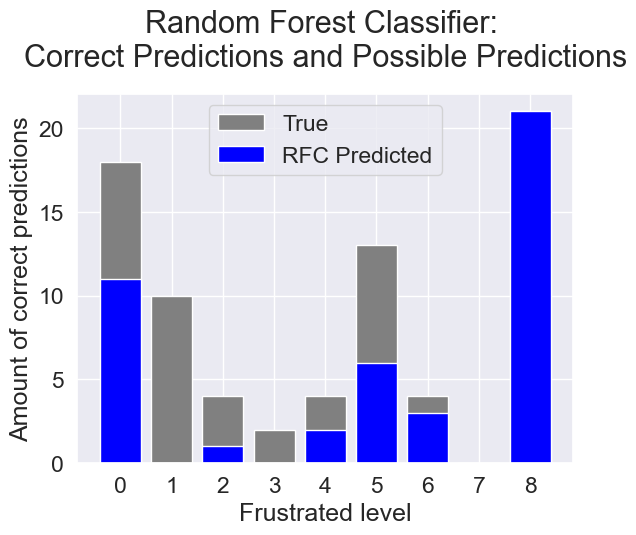

In [198]:
datapoints = [y_test[i] for i in range(len(RFC_y_pred_test)) if RFC_y_pred_test[i] == y_test[i]]

plt.figure()
plt.bar(np.arange(0,9), np.bincount(y_test), color="gray", label="True")
plt.bar(np.arange(0,9), np.bincount(datapoints), color="blue", label="RFC Predicted")
plt.title("Random Forest Classifier: \nCorrect Predictions and Possible Predictions", fontsize=22, pad=20)
plt.xlabel("Frustrated level")
plt.ylabel("Amount of correct predictions")
plt.xticks(np.arange(0,9))
plt.legend()
plt.show()

# Model 2: KNN

In [214]:
from sklearn.model_selection import StratifiedGroupKFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.dummy import DummyClassifier


# Baseline model
# baseline_model = DummyClassifier(strategy="constant", random_state=331, constant=int(summary["Frustrated"]["median"]))



fold_data = []

## -- Perform Stratified K-fold cross-validation to evaluate model generalization
## -- Compare it to a baseline

# Split into stratified KFolds
sgkf = StratifiedGroupKFold(n_splits=10, shuffle=True, random_state=331)
for i, (train_idx, test_idx) in enumerate(sgkf.split(X_train, y_train, groups=individuals.loc[train_indices])):
    fold_data.append((X_train.iloc[train_idx], y_train[train_idx], X_train.iloc[test_idx], y_train[test_idx]))





## Model
# Outer loopo: Hyperparameter tuning of n_neighbors

params = [1, 2, 3, 5, 10, 20, 50, 100]
avg_scores = np.empty(shape=(2, len(params)))
avg_scores[0,:] = params

KNN_CV_scores = np.empty(shape=(len(params), 10))
KNN_CV_mse = np.empty(shape=(len(params), 10))


for k in range(len(params)):
    
    knc = KNeighborsClassifier(n_neighbors=params[k])

    knc_scores = []
    knc_mse = []
    baseline_scores = []

    # Inner loop: Cross-validation for generalisation estimation
    for i, (X_train_sgkf, y_train_sgkf, X_test_sgkf, y_test_sgkf) in enumerate(fold_data):
        # print("Fold {}:   Train-IDs: {}. Test-IDs: {}".format(i, X_train_sgkf["Individual"].unique(), X_test_sgkf["Individual"].unique()))

        knc.fit(X_train_sgkf, y_train_sgkf)    
        knc_scores.append( knc.score(X_test_sgkf, y_test_sgkf) )
        knc_mse.append( mean_squared_error(y_true=y_test_sgkf, y_pred=knc.predict(X_test_sgkf)) )

        # Baseline model
        #baseline_model.fit(X_train_sgkf, y_train_sgkf)
        #baseline_scores.append( baseline_model.score(X_test_sgkf, y_test_sgkf) )
        
        # if (i == 2):
        #     print("Fold {}:   Train-IDs: {}. Test-IDs: {}".format(i, X_train_sgkf["Individual"].unique(), X_test_sgkf["Individual"].unique()))
    


    KNN_CV_scores[k] = knc_scores
    KNN_CV_mse[k] = knc_mse
    avg_acc = np.mean(knc_scores)
    avg_mse = np.mean(knc_mse)
    avg_scores[1,k] = avg_acc
    print(f"KNeighborsClassifier Average (n_neighbors={params[k]}): {avg_acc:.2f},    Mean MSE: {avg_mse:.2f}")
    #print("\nBaseline CV-scores:", baseline_scores)
    #print(f"Baseline Accuracy: {np.mean(baseline_scores):.2f}")


knn_best_k = np.where(avg_scores[1,:] == np.max(avg_scores[1,:]))[0][0]
print("\nBest choice of n_neighbours:", params[knn_best_k])
print(f"Best choice by MSE: {np.min(np.mean(KNN_CV_mse, axis=1)):.2f}")

print(f"\nKNeighborsClassifier CV-scores (n_neighbours={params[knn_best_k]}):", KNN_CV_scores[knn_best_k])

knc = KNeighborsClassifier(n_neighbors=params[knn_best_k])
knc.fit(X_train, y_train)

KNN_y_pred_test = knc.predict(X_test)

print(f"\n\nKNeighborsClassifier predictions: {KNN_y_pred_test}")
print(f"\n\nKNeighborsClassifier truth: {y_test}")

print(f"\n\nKNeighborsClassifier final Accuracy-test score: {knc.score(X_test, y_test):.2f}")
print(f"\nKNeighborsClassifier final MSE: {mean_squared_error(y_true=y_test, y_pred=KNN_y_pred_test):.2f}")

print("---")
# Baseline model
baseline_model = DummyClassifier(strategy="constant", random_state=331, constant=int(6))
baseline_model.fit(X_train, y_train)
print("Baseline:", baseline_model.score(baseline_model.predict(X_test), y_test))
print("Baseline MSE:", mean_squared_error(y_pred=baseline_model.predict(X_test), y_true=y_test))


KNeighborsClassifier Average (n_neighbors=1): 0.45,    Mean MSE: 6.52
KNeighborsClassifier Average (n_neighbors=2): 0.42,    Mean MSE: 6.82
KNeighborsClassifier Average (n_neighbors=3): 0.39,    Mean MSE: 8.35
KNeighborsClassifier Average (n_neighbors=5): 0.32,    Mean MSE: 10.30
KNeighborsClassifier Average (n_neighbors=10): 0.30,    Mean MSE: 11.26
KNeighborsClassifier Average (n_neighbors=20): 0.23,    Mean MSE: 12.86
KNeighborsClassifier Average (n_neighbors=50): 0.22,    Mean MSE: 16.02
KNeighborsClassifier Average (n_neighbors=100): 0.15,    Mean MSE: 14.08

Best choice of n_neighbours: 1
Best choice by MSE: 6.52

KNeighborsClassifier CV-scores (n_neighbours=1): [0.38888889 0.5        0.59090909 0.41509434 0.16666667 0.42857143
 0.72727273 0.3255814  0.58333333 0.33333333]


KNeighborsClassifier predictions: [4 5 1 5 5 0 4 5 0 2 4 1 0 8 2 0 2 0 5 5 0 0 5 2 0 5 0 0 8 3 0 3 8 0 5 2 0
 0 0 6 5 5 5 5 5 5 5 5 5 5 5 6 6 5 6 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8
 8 8]


KNeighborsClassi

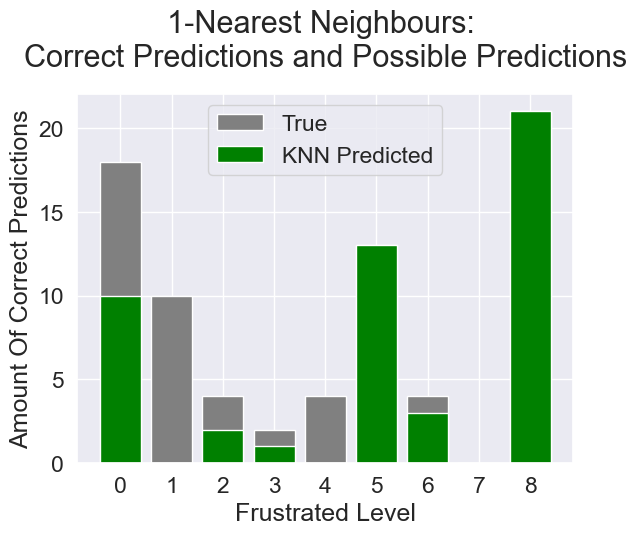

In [200]:
datapoints = [y_test[i] for i in range(len(KNN_y_pred_test)) if KNN_y_pred_test[i] == y_test[i]]

plt.figure()
plt.bar(np.arange(0,9), np.bincount(y_test), color="gray", label="True")
plt.bar(np.arange(0,9), np.bincount(datapoints), color="green", label="KNN Predicted")
plt.title(f"{params[knn_best_k]}-Nearest Neighbours: \nCorrect Predictions and Possible Predictions", fontsize=22, pad=20)
plt.xlabel("Frustrated Level")
plt.ylabel("Amount Of Correct Predictions")
plt.xticks(np.arange(0,9))
plt.legend()
plt.show()

# Model 3: SVM

In [201]:
from sklearn.model_selection import StratifiedGroupKFold
from sklearn.svm import SVC
from sklearn.dummy import DummyClassifier


# Baseline model
baseline_model = DummyClassifier(strategy="constant", random_state=331, constant=int(summary["Frustrated"]["median"]))

## Model
# Outer loop: Hyperparameter tuning of regularization parameter "C"

params = [1, 2, 3, 5, 10, 20, 50, 100, 200, 300, 500, 1000, 10000]
avg_scores = np.empty(shape=(2, len(params)))
avg_scores[0,:] = params

SVC_CV_scores = np.empty(shape=(len(params), 10))
SVC_CV_mse = np.empty(shape=(len(params), 10))

for k in range(len(params)):
    
    svc = SVC(random_state=331, C=params[k], gamma=0.3, kernel="rbf") # Selected gamma by trial-and-error.

    svc_scores = []
    svc_mse = []
    baseline_scores = []
    ##

    fold_data = []

    ## -- Perform Stratified K-fold cross-validation to evaluate model generalization
    ## -- Compare it to a baseline

    # Split into stratified KFolds
    sgkf = StratifiedGroupKFold(n_splits=10, shuffle=True, random_state=331)
    for i, (train_idx, test_idx) in enumerate(sgkf.split(X_train, y_train, groups=individuals.loc[train_indices])):
        fold_data.append((X_train.iloc[train_idx], y_train[train_idx], X_train.iloc[test_idx], y_train[test_idx]))


    svc_scores = []
    baseline_scores = []

    for i, (X_train_sgkf, y_train_sgkf, X_test_sgkf, y_test_sgkf) in enumerate(fold_data):
        #print("Fold {}:   Train-IDs: {}. Test-IDs: {}".format(i, X_train_sgkf["Individual"].unique(), X_test_sgkf["Individual"].unique()))

        svc.fit(X_train_sgkf, y_train_sgkf)    
        svc_scores.append( svc.score(X_test_sgkf, y_test_sgkf) )
        svc_mse.append( mean_squared_error(y_true=y_test_sgkf, y_pred=svc.predict(X_test_sgkf)) )

        # Baseline model
        baseline_model.fit(X_train_sgkf, y_train_sgkf)
        baseline_scores.append( baseline_model.score(X_test_sgkf, y_test_sgkf) )


    
    SVC_CV_scores[k] = svc_scores
    SVC_CV_mse[k] = svc_mse
    avg_acc = np.mean(svc_scores)
    avg_mse = np.mean(svc_mse)
    avg_scores[1,k] = avg_acc
    print(f"SupportVectorClassifier Average Accuracy (regularization={params[k]}): {avg_acc:.2f},    Mean MSE: {avg_mse:.2f}")



svc_best_k = np.where(avg_scores[1,:] == np.max(avg_scores[1,:]))[0][0]
print("\nBest choice of regularization: C =", params[svc_best_k])
print(f"Best choice by MSE: {np.min(np.mean(SVC_CV_mse, axis=1)):.2f}")


print(f"\nSupportVectorClassifier CV-scores (regularization={params[svc_best_k]}):", SVC_CV_scores[svc_best_k])


# print("\n\nSupportVectorClassifier CV-scores:", svc_scores)
# print(f"SupportVectorClassifier Average: {np.mean(svc_scores):.2f}")

svc = SVC(random_state=331, C=params[svc_best_k], gamma=0.3, kernel="rbf")
svc.fit(X_train, y_train)

SVC_y_pred_test = svc.predict(X_test)

print(f"\n\nSupportVectorClassifier predictions: {SVC_y_pred_test}")
print(f"\n\nSupportVectorClassifier truth: {y_test}")

print(f"\nSupportVectorClassifier final Accuracy-test score: {svc.score(X_test, y_test):.2f}")
print(f"\nSupportVectorClassifier final MSE: {mean_squared_error(y_true=y_test, y_pred=SVC_y_pred_test):.2f}")

# print("\n-----\nBaseline CV-scores:", baseline_scores)
# print(f"Baseline Accuracy: {np.mean(baseline_scores):.2f}")

SupportVectorClassifier Average Accuracy (regularization=1): 0.40,    Mean MSE: 4.75
SupportVectorClassifier Average Accuracy (regularization=2): 0.45,    Mean MSE: 4.19
SupportVectorClassifier Average Accuracy (regularization=3): 0.46,    Mean MSE: 4.14
SupportVectorClassifier Average Accuracy (regularization=5): 0.46,    Mean MSE: 4.14
SupportVectorClassifier Average Accuracy (regularization=10): 0.48,    Mean MSE: 4.09
SupportVectorClassifier Average Accuracy (regularization=20): 0.49,    Mean MSE: 4.59
SupportVectorClassifier Average Accuracy (regularization=50): 0.49,    Mean MSE: 4.58
SupportVectorClassifier Average Accuracy (regularization=100): 0.49,    Mean MSE: 4.58
SupportVectorClassifier Average Accuracy (regularization=200): 0.49,    Mean MSE: 4.58
SupportVectorClassifier Average Accuracy (regularization=300): 0.49,    Mean MSE: 4.58
SupportVectorClassifier Average Accuracy (regularization=500): 0.49,    Mean MSE: 4.58
SupportVectorClassifier Average Accuracy (regularizati

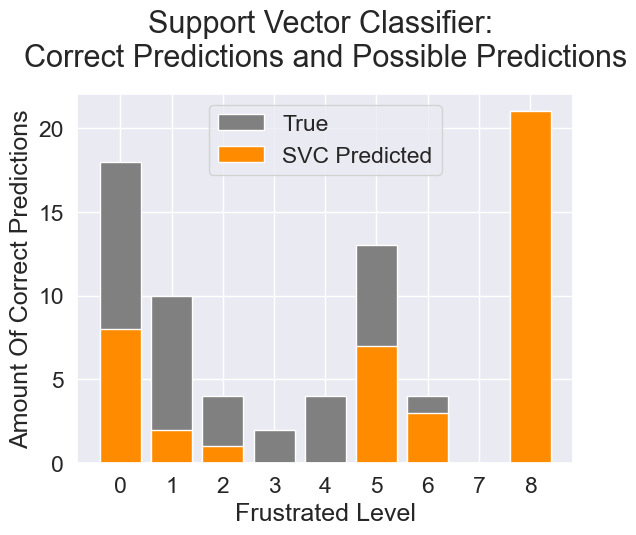

In [202]:
datapoints = [y_test[i] for i in range(len(SVC_y_pred_test)) if SVC_y_pred_test[i] == y_test[i]]

plt.figure()
plt.bar(np.arange(0,9), np.bincount(y_test), color="gray", label="True")
plt.bar(np.arange(0,9), np.bincount(datapoints), color="darkorange", label="SVC Predicted")
plt.title(f"Support Vector Classifier: \nCorrect Predictions and Possible Predictions", fontsize=22, pad=20)
plt.xlabel("Frustrated Level")
plt.ylabel("Amount Of Correct Predictions")
plt.xticks(np.arange(0,9))
plt.legend()
plt.show()

### Note:

The models are only trained on the "Frustrated" ratings 0-8, as there are no datapoints in the dataset for ratings 9 and 10.

This could be creatively handled by somehow introducing a threshold upon the X_train data, so if the data crosses the threshold it will be classified as ratings 9 or 10, treating it as an unsupervised problem.
A threshold could be distance based, so if the e.g. euclidean distance to any datapoint or cluster is greater than the threshold, it will be classified as one of the missing ratings.

This however is considered beyond the scope of this report, where model evaluation and comparison are central, and since no test data for the for the ratings 9-10 is available, verifying the results would prove unfeasible.

# Model Comparison

## Plot of Correct Predictions by Model

Plot of the different models correct predictions of each Frustrated Level in percentages of the total amount possible.

I.e. Correct Predictions as Percentage of the True Test Data.

In [203]:
accuracy1 = [y_test[i] for i in range(len(RFC_y_pred_test)) if RFC_y_pred_test[i] == y_test[i]]
accuracy2 = [y_test[i] for i in range(len(KNN_y_pred_test)) if KNN_y_pred_test[i] == y_test[i]]
accuracy3 = [y_test[i] for i in range(len(SVC_y_pred_test)) if SVC_y_pred_test[i] == y_test[i]]

truth = np.bincount(y_test)
RFC_dp = np.bincount(accuracy1)
KNN_dp = np.bincount(accuracy2)
SVC_dp = np.bincount(accuracy3)

RFC_percent = np.divide(RFC_dp, truth, out=np.zeros_like(RFC_dp, dtype=float), where=truth!=0)*100
KNN_percent = np.divide(KNN_dp, truth, out=np.zeros_like(KNN_dp, dtype=float), where=truth!=0)*100
SVC_percent = np.divide(SVC_dp, truth, out=np.zeros_like(SVC_dp, dtype=float), where=truth!=0)*100


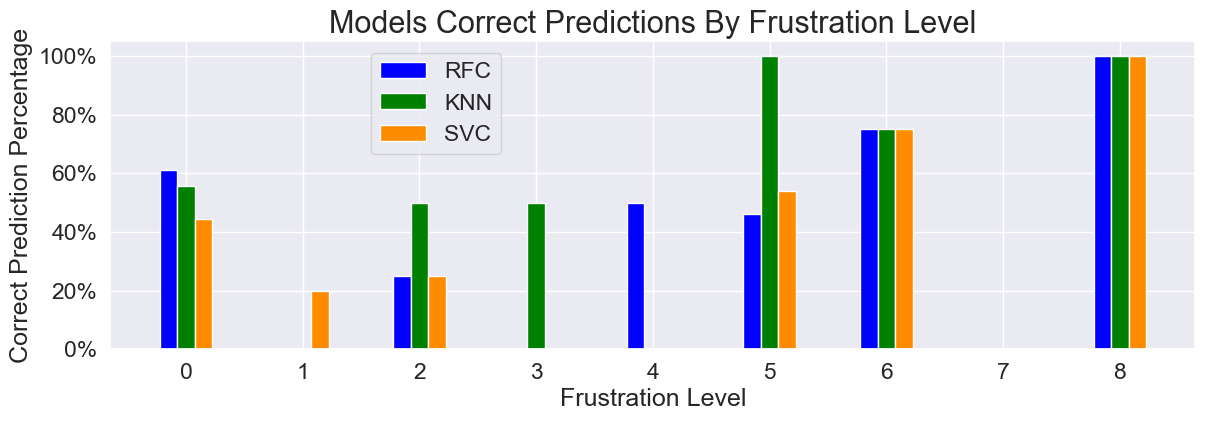

In [204]:
import matplotlib.ticker as mticker
sns.set_theme(font_scale=1.5)

# Define the labels for the x-axis
labels = np.arange(0, 9)

# Define the width of the bars
width = 0.15

# Create a figure and a set of subplots
fig, ax = plt.subplots(figsize=(14, 4))

# Add bars for RFC_percent and KNN_percent
ax.bar(labels - width, RFC_percent, width, label='RFC', color="blue")
ax.bar(labels, KNN_percent, width, label='KNN', color="green")
ax.bar(labels + width, SVC_percent, width, label='SVC', color="darkorange")
# ax.axhline(y=100, color='k', alpha=0.5)

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_xlabel('Frustration Level')
ax.set_ylabel('Correct Prediction Percentage')
ax.set_title('Models Correct Predictions By Frustration Level', fontsize=22)
ax.set_xticks(labels)
ax.yaxis.set_major_formatter(mticker.PercentFormatter())
ax.legend(loc=9, bbox_to_anchor=(0.3, 1))

# Show the plot
plt.savefig("Models_Correct_Predictions_By_Frustration_Level.pdf", bbox_inches='tight')


!!!: The high 8-prediction rate (100% of 7 total) could be caused by over-sampling (SMOTE) from only 2 "8"-datapoints in data preprocessing.

## Table of CV-scores

In [205]:
## -- Record Scores For Each Model

cv_scores = [
    ["RFC", RFC_CV_scores[rfc_best_k]], 
    ["KNN", KNN_CV_scores[knn_best_k]],
    ["SVC", SVC_CV_scores[svc_best_k]]
    ]

data = np.empty([len(cv_scores), 10])
labels = []

print("Cross-validation scores for each model:")
for i in range(len(cv_scores)):
    print(f"     {cv_scores[i][0]}:", np.round(cv_scores[i][1],4))
    data[i] = cv_scores[i][1]
    labels.append(cv_scores[i][0])


df_cv = pd.DataFrame(data.T, columns=labels)

Cross-validation scores for each model:
     RFC: [0.3333 0.5385 0.5758 0.6604 0.2333 0.4762 0.6364 0.3256 0.5833 0.4667]
     KNN: [0.3889 0.5    0.5909 0.4151 0.1667 0.4286 0.7273 0.3256 0.5833 0.3333]
     SVC: [0.6667 0.3846 0.5303 0.5283 0.1    0.7143 0.697  0.2558 0.5    0.5333]


In [206]:
df_cv

,RFC,KNN,SVC
0,0.333333,0.388889,0.666667
1,0.538462,0.500000,0.384615
2,0.575758,0.590909,0.530303
3,0.660377,0.415094,0.528302
4,0.233333,0.166667,0.100000
5,0.476190,0.428571,0.714286
6,0.636364,0.727273,0.696970
7,0.325581,0.325581,0.255814
8,0.583333,0.583333,0.500000
9,0.466667,0.333333,0.533333


## ANOVA

### Assumptions check

#### Normality:

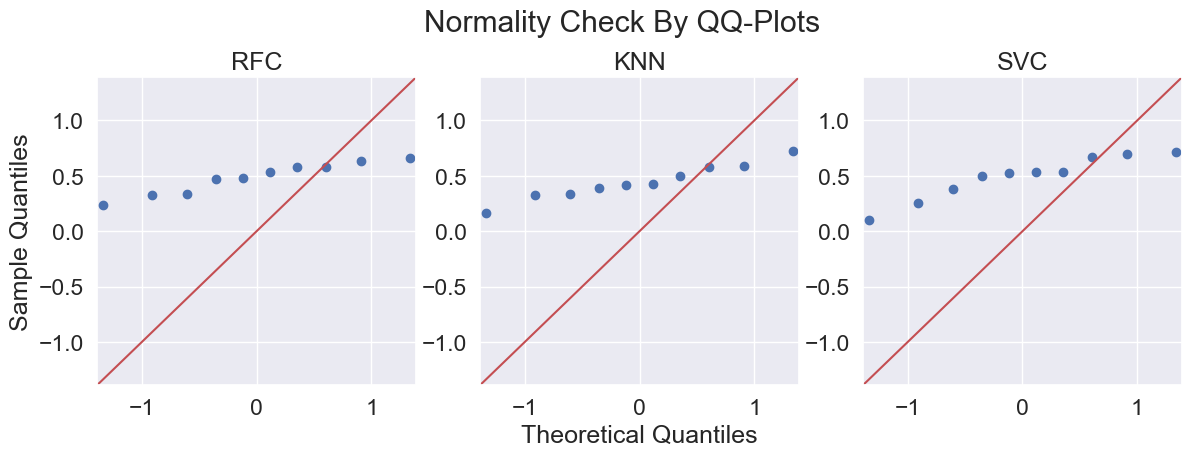

In [207]:
import statsmodels.api as sm # to make the QQ-plot

np.random.seed(331) # Set a seed for reproducibility of randomness

fig, ax = plt.subplots(1, 3, figsize=(14, 4))

for i in range(3):
    sm.qqplot(df_cv[df_cv.columns[i]], line='45', ax=ax[i])
    if i > 0: ax[i].set_ylabel('')
    if i == 0 or i == 2: ax[i].set_xlabel('')
    ax[i].set_title(labels[i])

plt.suptitle("Normality Check By QQ-Plots", y=1.05)
plt.show()

## Friedman

### Assumptions

Source: https://statistics.laerd.com/spss-tutorials/friedman-test-using-spss-statistics.php

\
\
Assumption #1: One group that is measured on three or more different occasions.
* Each fold in cross-validation measured on different occasions (i.e. for different models). Assumption is met since the data are accuracy scores for different models across the same folds.

Assumption #2: Group is a random sample from the population.
* The cross-validation folds are randomly selected (although consistently by random_state=331, but this doesn't affect the assumption).

Assumption #3: Your dependent variable should be measured at the ordinal or continuous level.
* The accuracy scores are continuous, and even ordinal, so this assumption is met.

Assumption #4: Samples do NOT need to be normally distributed.
* The CV-scores are not normally distributed.

In [208]:
from scipy.stats import friedmanchisquare

stat, p = friedmanchisquare(df_cv['RFC'], df_cv['KNN'], df_cv['SVC'])

print(f'Friedman Test Statistic: {stat}')
significance = "Significant difference." if p < 0.05 else "Insignificant difference."

print('P-Value: {}          ({})'.format(p, significance))

Friedman Test Statistic: 0.8421052631579068
P-Value: 0.6563555554708362          (Insignificant difference.)


## Nemenyi post-hoc test

*"Nemenyi test is a post-hoc test intended to find the groups of data that differ after a global statistical test (such as the Friedman test) has rejected the null hypothesis"* - Wikipedia

In [209]:
import scikit_posthocs as sp

# Perform the Nemenyi post-hoc test
nemenyi = sp.posthoc_nemenyi_friedman(df_cv)

print(nemenyi)

          RFC       KNN       SVC
RFC  1.000000  0.887683  0.631856
KNN  0.887683  1.000000  0.887683
SVC  0.631856  0.887683  1.000000


## Friedman MSE

In [210]:
## -- Record Scores For Each Model

cv_scores = [
    ["RFC", RFC_CV_mse[rfc_best_k]], 
    ["KNN", KNN_CV_mse[knn_best_k]],
    ["SVC", SVC_CV_mse[svc_best_k]]
    ]

data = np.empty([len(cv_scores), 10])
labels = []

print("Cross-validation scores for each model:")
for i in range(len(cv_scores)):
    print(f"     {cv_scores[i][0]}:", np.round(cv_scores[i][1],4))
    data[i] = cv_scores[i][1]
    labels.append(cv_scores[i][0])


df_cv = pd.DataFrame(data.T, columns=labels)
df_cv

Cross-validation scores for each model:
     RFC: [ 9.8889  3.6538  2.      1.4906  8.7333 10.1905  3.5455 11.0698  6.1667
  2.0667]
     KNN: [ 4.5     4.5     1.7424  8.1132  5.3333 21.619   0.9394  4.4651  9.9583
  4.    ]
     SVC: [ 1.7222  3.0769  2.5758  3.6226 10.1333  1.      1.0606 11.2791 10.8333
  0.4667]


,RFC,KNN,SVC
0,9.888889,4.500000,1.722222
1,3.653846,4.500000,3.076923
2,2.000000,1.742424,2.575758
3,1.490566,8.113208,3.622642
4,8.733333,5.333333,10.133333
5,10.190476,21.619048,1.000000
6,3.545455,0.939394,1.060606
7,11.069767,4.465116,11.279070
8,6.166667,9.958333,10.833333
9,2.066667,4.000000,0.466667


In [211]:
from scipy.stats import friedmanchisquare

stat, p = friedmanchisquare(df_cv['RFC'], df_cv['KNN'], df_cv['SVC'])

print(f'Friedman Test Statistic: {stat}')
significance = "Significant difference." if p < 0.05 else "Insignificant difference."

print('P-Value: {}          ({})'.format(p, significance))

Friedman Test Statistic: 0.0
P-Value: 1.0          (Insignificant difference.)


# Discussion

Points for discussion:

* "Frustrated" levels were qualitative assesments recorded by the individuals themselves, which which may have create inconsistencies in the data due to the individuals subjective assesment of their own mental state. A method, which in other medical or judicial cases would be entirely out of the question.